<a href="https://www.kaggle.com/lucasbenazzicestari/basic-correlation-analysis-of-covid-19-worldwide?scriptVersionId=89151874" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Basic Correlation Analysis of COVID-19 Cases Worldwide


### Introduction


In this notebook we will do a basic correlation analysis of covid data available at **https://www.kaggle.com/abhimaneukj/covid19-dataset** by **CaptainClever**.


The general idea is to correlate **absolute** and **per million population** values of:

* **cases**

* **deaths**

* **tests**

* **vaccines**

* **population**

* **median age**

* **GPD per capita**

With this, we can see which information is related and by how much.

#### Basic sumarry of the code

* open the dataset
* deal with null values
* divide the data into relevant groups
* create a heatmap for each relevant group
* conclusion based on correlation values

In [1]:
# we first start with the imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# some functions return a warning, which isn't important for us right now
import warnings
warnings.filterwarnings("ignore")

In [2]:
# open the relevant csv data
all_covid_data = pd.read_csv("../input/covid19-dataset/COVID-19 Dataset.csv")

In [3]:
# print out the head of the dataset
all_covid_data.head(5)

,Continent,Country,Last_Updated_Date,Total_Cases,Total_Deaths,Total_Cases_Per_Million,Total_Deaths_Per_Million,Total_tests,Positive_rate,Total_Vaccinations,People_Vaccinated,People_Fully_Vaccinated,Population,Population_Density,Median_Age,Aged_65_Older,Aged_70_Older,GDP_Per_Capita
0,Asia,Afghanistan,11-10-2021,155540.0,7228.0,3904.565,181.447,NaN,NaN,2369625.0,828601.0,NaN,39835428,54.422,18.6,2.581,1.337,1803.987
1,Europe,Albania,11-10-2021,175163.0,2777.0,60970.074,966.608,NaN,NaN,1795351.0,962281.0,833070.0,2872934,104.871,38.0,13.188,8.643,11803.431
2,Africa,Algeria,11-10-2021,204695.0,5855.0,4587.864,131.229,NaN,NaN,NaN,NaN,NaN,44616626,17.348,29.1,6.211,3.857,13913.839
3,Europe,Andorra,11-10-2021,15307.0,130.0,197882.462,1680.585,215733.0,0.054,NaN,NaN,NaN,77354,163.755,NaN,NaN,NaN,NaN
4,Africa,Angola,11-10-2021,61580.0,1629.0,1814.720,48.006,NaN,NaN,4074677.0,2863708.0,1210969.0,33933611,23.890,16.8,2.405,1.362,5819.495


In [4]:
# get the shape of the dataset
all_covid_data.shape

(216, 18)

In [5]:
# check for null values
all_covid_data.isnull().sum()

Continent                     2
Country                       0
Last_Updated_Date             0
Total_Cases                  21
Total_Deaths                 28
Total_Cases_Per_Million      21
Total_Deaths_Per_Million     28
Total_tests                 112
Positive_rate               111
Total_Vaccinations           17
People_Vaccinated            22
People_Fully_Vaccinated      20
Population                    0
Population_Density           12
Median_Age                   27
Aged_65_Older                29
Aged_70_Older                28
GDP_Per_Capita               25
dtype: int64

We can see that there are plenty of null values in some columns.


One row that stands out and is worth taking a closer look is in the **Continent** column, where we wouldn't expect to see a null value.

In [6]:
# check the rows where "Continent == null"
all_covid_data.loc[all_covid_data['Continent'].isnull()]

,Continent,Country,Last_Updated_Date,Total_Cases,Total_Deaths,Total_Cases_Per_Million,Total_Deaths_Per_Million,Total_tests,Positive_rate,Total_Vaccinations,People_Vaccinated,People_Fully_Vaccinated,Population,Population_Density,Median_Age,Aged_65_Older,Aged_70_Older,GDP_Per_Capita
144,NaN,North America,11-10-2021,53474030.0,1084066.0,89634.106,1817.130,NaN,NaN,638851988.0,350483642.0,289888363.0,596581283,NaN,NaN,NaN,NaN,NaN
147,NaN,Oceania,11-10-2021,210720.0,2388.0,4875.526,55.252,NaN,NaN,39278629.0,22691197.0,16587432.0,43219954,NaN,NaN,NaN,NaN,NaN


We can see that in these cases, each row is representing a continent and not a country.

For the purpose of this notebook, and to avoid the case where some values are analysed twice, we are going to drop these columns.

In [7]:
# drop these rows
all_covid_data = all_covid_data[~(all_covid_data['Continent'].isnull())]

We will drop the columns **Continent** and **Last_Updated_date** as they are not the focus of this analysis.

In [8]:
all_covid_data = all_covid_data.drop(['Continent','Last_Updated_Date'], axis = 1)

We are going to set **Country** as an index since we are only using it as a label, and not to draw information.

In [9]:
covid_data = all_covid_data.set_index('Country')

In [10]:
# checking again for null values just so we don't have to scroll up again ;)
covid_data.isnull().sum()

Total_Cases                  21
Total_Deaths                 28
Total_Cases_Per_Million      21
Total_Deaths_Per_Million     28
Total_tests                 110
Positive_rate               109
Total_Vaccinations           17
People_Vaccinated            22
People_Fully_Vaccinated      20
Population                    0
Population_Density           10
Median_Age                   25
Aged_65_Older                27
Aged_70_Older                26
GDP_Per_Capita               23
dtype: int64

Some columns we can replace null values with zero. These are:
* Total_Cases
* Total_Deaths
* Total_Cases_Per_Million
* Total_Deaths_Per_Million
* Total_tests
* Positive_rate
* Total_Vaccinations
* People_Vaccinated
* People_Fully_Vaccinated

We will replace these values with zero and drop the rows where one of the other values is null.

In [11]:
# creating a list of the columns where NaN should be 0
columns_to_replace_zeros = [
    'Total_Cases',
    'Total_Deaths',
    'Total_Cases_Per_Million',
    'Total_Deaths_Per_Million',
    'Total_tests',
    'Positive_rate',
    'Total_Vaccinations',
    'People_Vaccinated',
    'People_Fully_Vaccinated'
]

# replacing null values with zeros
covid_data[columns_to_replace_zeros] = covid_data[columns_to_replace_zeros].fillna(0)

# dropping the remaining rows where at least one value is still null
covid_data = covid_data.dropna()

Before we continue, we'll add some extra columns:
* Total_tests_Per_Million
* Positive_rate_Per_Million
* Total_Vaccinations_Per_Million
* People_Vaccinated_Per_Million
* People_Fully_Vaccinated_Per_Million

As their name implies, they are the **per million** values of some columns.

In [12]:
# base columns used for calculations
base_columns = [
    'Total_tests',
    'Positive_rate',
    'Total_Vaccinations',
    'People_Vaccinated',
    'People_Fully_Vaccinated'
]

# columns that will be created
new_columns = [
    'Total_tests_Per_Million',
    'Positive_rate_Per_Million',
    'Total_Vaccinations_Per_Million',
    'People_Vaccinated_Per_Million',
    'People_Fully_Vaccinated_Per_Million'
]

# calculation of "per million" values for each column
covid_data[new_columns] = covid_data[base_columns].div(covid_data['Population'], axis=0) * 1000000

To decide which method to calculate the correlation index, it's important to know if the values follow a normal distribution.

To do that, we are simply going to do a box plot of all values.


We are first going to **normalize** all values between **0** and **1**, so we can fit all of them on the same figure.


We will also use these normalized values for plotting multiple columns together.

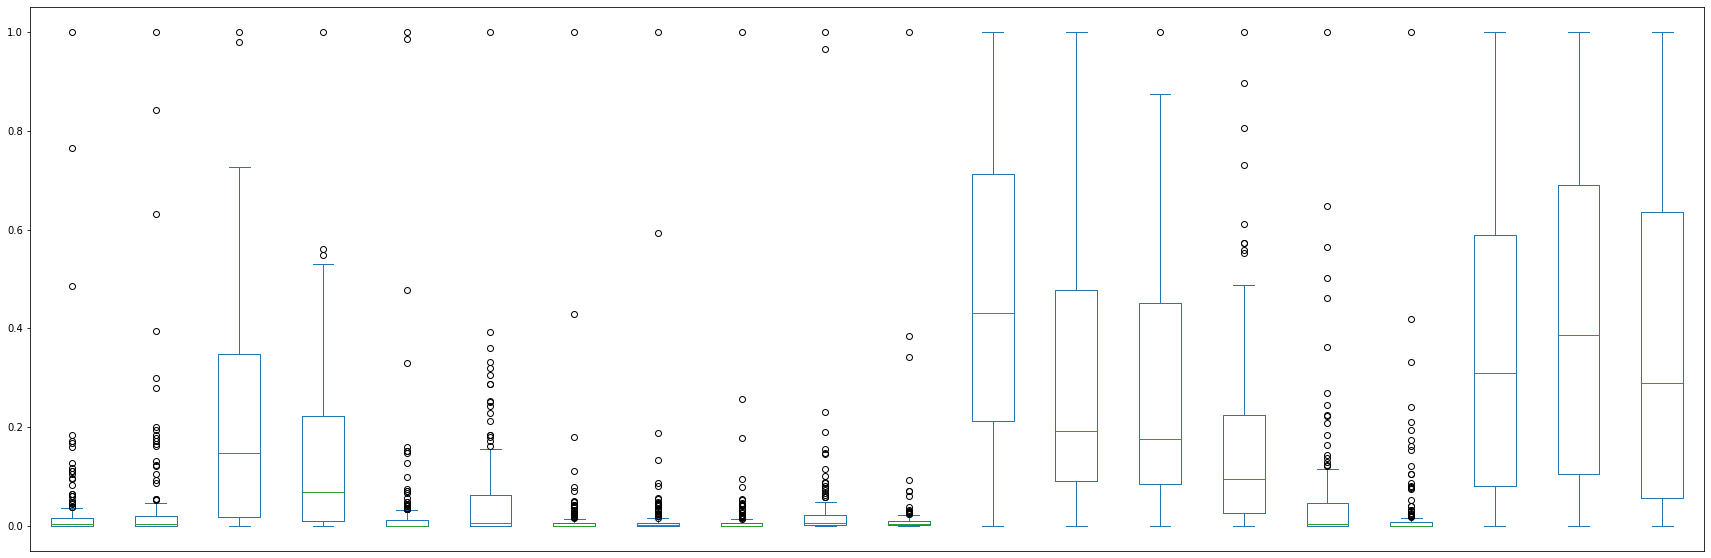

In [13]:
# normalize the values between 0 and 1 and plot to see if they follow a normal distribution
normalized_df = (covid_data - covid_data.min()) / (covid_data.max() - covid_data.min())

normalized_df.plot(kind = 'box', figsize = (30,10))

# turn off axis as in this case they aren't individually relevant
plt.tick_params(
    axis='x',
    bottom=False,
    labelbottom=False)
plt.show()

We can see that most values don't follow a normal distribution, so we won't be using the **Pearson's** method.


We will use **Spearman's** method instead.


We will first plot the whole data correlation map and analyse the data in segments later.


Useful links:

* https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
* https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
* http://geoinfo.amu.edu.pl/qg/archives/2011/QG302_087-093.pdf

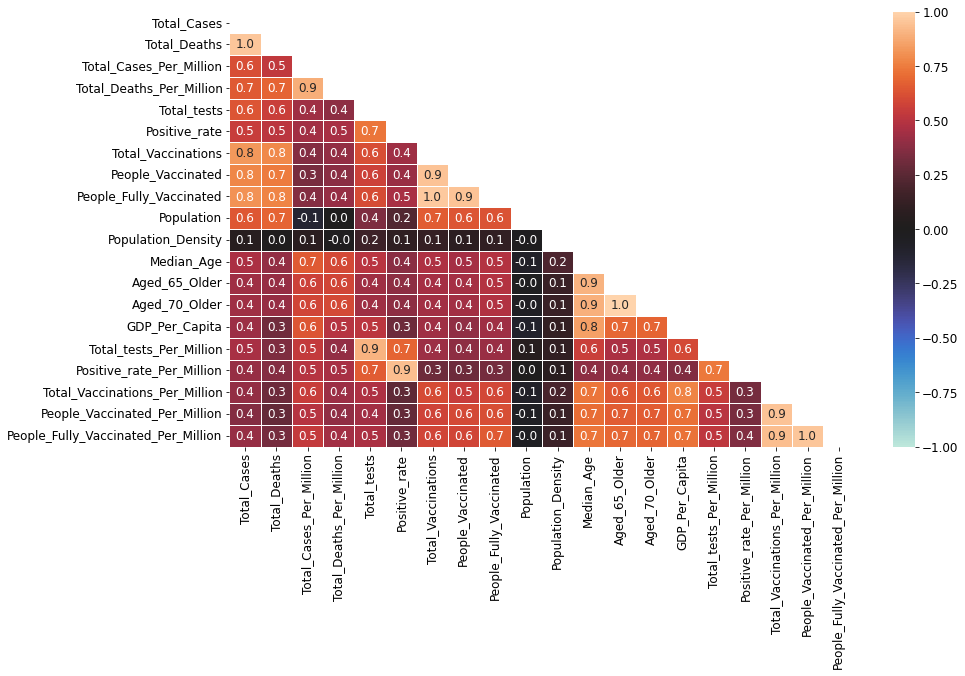

In [14]:
# since we are going to make multiple boxplots, we are going to create a function that takes in a dataset and plots a boxplot.
# we are going to add the variable "columns_to_show", so we can filter a group of columns at a time.
# we are also going to add the variable "rows_to_omit" to filter out rows. This will be helpful to avoid seeing the sam
# combination of values together multiple times

# dataset - must be a pandas dataframe
# columns_to_show - if not None, must be a list with valid column names
# figsize - turple with two numbers
# font_size - number

def create_heatmap(dataset, columns_to_show = None, rows_to_omit = None, fig_size = (14,8), font_size = 12):
    # creating the correlation map using the Spearman's method
    corr = dataset.corr(method = 'spearman')
    
    # only create a mask if "columns_to_show" isn't given
    if columns_to_show == None:
        mask = np.zeros_like(corr, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        corr[mask] = np.nan
    else:
        corr = corr[columns_to_show]
        # if "rows_to_omit" is given, drop these rows
        if rows_to_omit != None:
            corr = corr.drop(rows_to_omit)
        
    # set font size and figure size
    plt.rcParams.update({'font.size':font_size})
    fig, ax = plt.subplots(figsize = fig_size)
    
    # I personally like to always set (vmin = -1, vmax = 1) and use diverging colormaps
    # For more information on colormaps, see https://matplotlib.org/stable/tutorials/colors/colormaps.html
    dataplot = sns.heatmap(
        corr,
        ax = ax,
        vmin = -1,
        vmax = 1,
        cmap="icefire",
        linewidths=1,
        annot = True,
        fmt = '.1f'
    )
    
    # displaying the heatmap
    fig.show()
    
# use our create_heatmap function will all of our data
create_heatmap(covid_data)

At a first glance, you can see that **Population_Density** has little correlation with **every other data**. Which means that even in countries with higher population densities, we don't have an increase in COVID-19 cases and deaths.

Besides that, we can see that most values have **some sort of correlation with every other value**.

Just as a extra little bit of visual data, we will plot **Population_Density** and **Total_Cases** together normalized to show the lack of correlation.

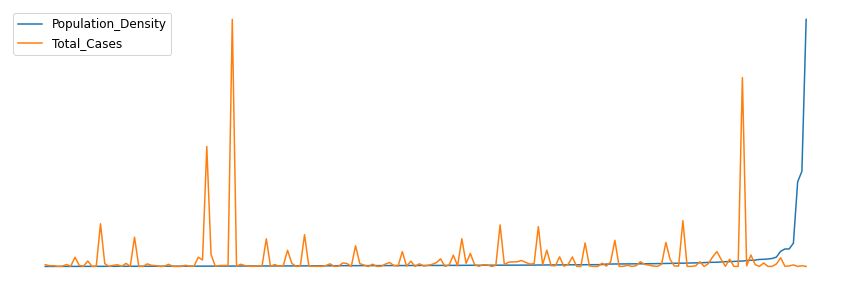

In [15]:
plt.figure(figsize=(15,5))
plt.plot(normalized_df[['Population_Density','Total_Cases']].sort_values('Population_Density'))
plt.axis('off')
plt.legend(['Population_Density','Total_Cases'])
plt.show()

To help deal with the large number of columns, we are going to separate them into relevant groups:
* **cases_death_related**
    * Total_Cases, Total_Deaths, Total_Cases_Per_Million, Total_Deaths_Per_Million
* **test_related**
    * Total_tests, Positive_rate, Total_tests_Per_Million, Positive_rate_Per_Million
* **vaccine_related**
    * Total_Vaccinations, People_Vaccinated, People_Fully_Vaccinated, Total_Vaccinations_Per_Million, People_Vaccinated_Per_Million, People_Fully_Vaccinated_Per_Million
* **population_related**
    * Population, Population_Density
* **age_related**
    * Median_Age, Aged_65_Older, Aged_70_Older
* **GPD_Per_Capita**
    * GPD_Per_Capita

In [16]:
cases_death_related = ['Total_Cases',
                       'Total_Deaths',
                       'Total_Cases_Per_Million',
                       'Total_Deaths_Per_Million']

test_related = ['Total_tests',
                'Positive_rate',
                'Total_tests_Per_Million',
                'Positive_rate_Per_Million']

vaccine_related = ['Total_Vaccinations',
                   'People_Vaccinated',
                   'People_Fully_Vaccinated',
                   'Total_Vaccinations_Per_Million',
                   'People_Vaccinated_Per_Million',
                   'People_Fully_Vaccinated_Per_Million']

population_related = ['Population',
                      'Population_Density']

age_related = ['Median_Age',
               'Aged_65_Older',
               'Aged_70_Older']

GDP_Per_Capita = ['GDP_Per_Capita']


We are going to start with **cases_death_related**.

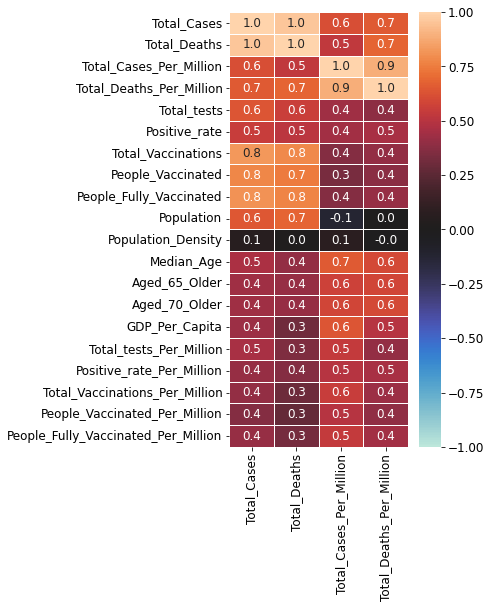

In [17]:
create_heatmap(
    dataset = covid_data,
    columns_to_show = cases_death_related,
    fig_size = (4,8))

**Some noteworthy correlations:**

* **Total_Cases** and **Total_Deaths** are extremely related. The same with **Total_Cases_Per_Million** and **Total_Deaths_Per_Million**.

* **Total_Cases** and **Total_Deaths** have a correlation with **Population**. However, **Total_Cases_Per_Million** and **Total_Deaths_Per_Million** don't correlate with **Population**.

* All **vaccine information** correlates more with **absolute values** than with **per million values**.

* **Age related information** correlates slightly more with **per million values** than with **absolute values**.

* **GDP_Per_Capita** has a significant correlation with **per million values**, more then with **absolute values**.

Moving on with **test_related**.

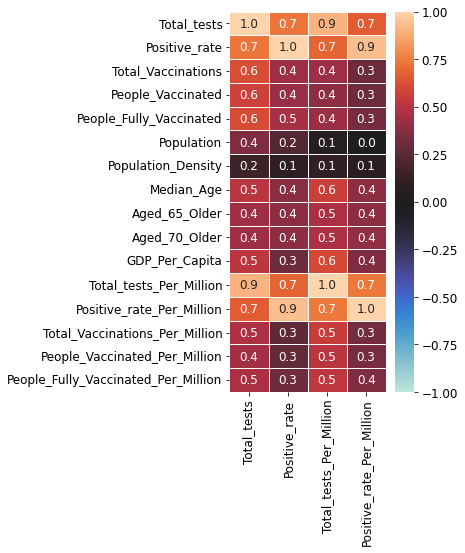

In [18]:
rows_to_omit = cases_death_related

create_heatmap(
    dataset = covid_data,
    columns_to_show = test_related,
    rows_to_omit = rows_to_omit,
    fig_size = (3.5,7))

**Some noteworthy correlations:**

* there is a extremely strong correlation between the **test related values themselves**.

* there is a significant correlation between **Total_tests** and **vaccination related** information.

* there is a significant correlation between **Median_Age** and **GDP_Per_Capita** with **Total_tests_Per_Million**.

Moving on with **vaccine_related**.

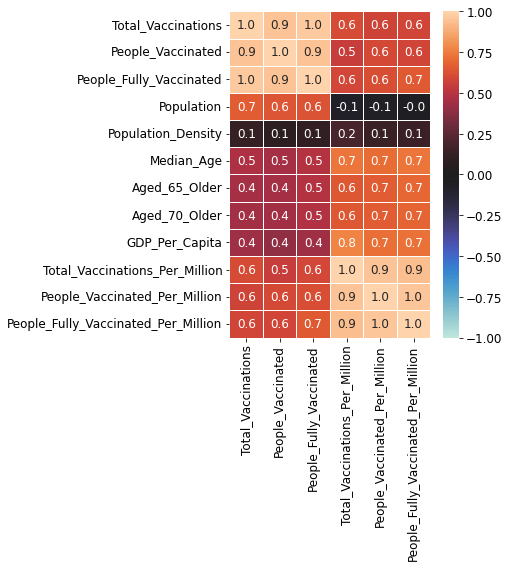

In [19]:
rows_to_omit = cases_death_related + test_related

create_heatmap(
    dataset = covid_data,
    columns_to_show = vaccine_related,
    rows_to_omit = rows_to_omit,
    fig_size = (4.5,6))

**Some noteworthy correlations:**

* There is an extremely strong correlation between the **test related values themselves**.

* There is a significant correlation between **Total_tests** and **vaccination related** information.

Moving on with **vaccine_related**.

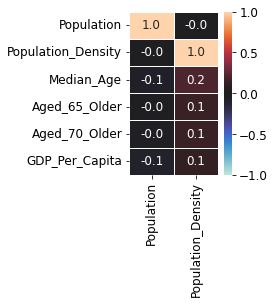

In [20]:
rows_to_omit = cases_death_related + test_related + vaccine_related

create_heatmap(
    dataset = covid_data,
    columns_to_show = population_related,
    rows_to_omit = rows_to_omit,
    fig_size = (2,3))


At this point, the correlations seen here were already noted before, so they won't be repeated here.

Moving on with **age_related** and **GDP_Per_Capita** together.

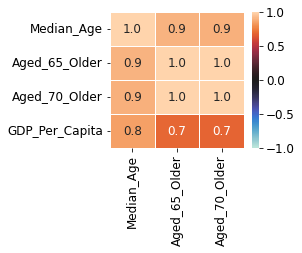

In [21]:
rows_to_omit = cases_death_related + test_related + vaccine_related + population_related
columns_to_show = age_related# + GDP_Per_Capita

create_heatmap(
    dataset = covid_data,
    columns_to_show = columns_to_show,
    rows_to_omit = rows_to_omit,
    fig_size = (3,2.5))

Same as when analysing **population_related** data, most correlations here were already mentioned, and won't be repeated.

**Some noteworthy correlations:**

* There is a significant correlation between all the values

### Summary of all noteworthy correlations:



* **Population_Density** has little correlation with **every other data**.

* **Total_Cases** and **Total_Deaths** are extremely related. The same with **Total_Cases_Per_Million** and **Total_Deaths_Per_Million**.

* **Total_Cases** and **Total_Deaths** have a correlation with **Population**. However, **Total_Cases_Per_Million** and **Total_Deaths_Per_Million** don't correlate with **Population**.

* All **vaccine information** correlates more with **absolute values** than with **per million values**.

* **Age related information** correlates slightly more with **per million values** than with **absolute values**.

* **GDP_Per_Capita** has a significant correlation with **per million values**, more then with **absolute values**.

* There is an extremely strong correlation between the **test related values themselves**.

* There is a significant correlation between **Total_tests** and **vaccination related** information.

* There is a significant correlation between **Median_Age** and **GDP_Per_Capita** with **Total_tests_Per_Million**.

* There is a extremely strong correlation between **absolute vaccination information with themselves**, and **per million vaccination information with themselves**. The correlation between the **absolute** and **per million** values isn't as strong, but it still has a significant correlation.

* There is a strong correlation between **age related information** and **GDP_Per_Capita** with **vaccination information per million**.

* There is a strong correlation between **Population** with **absolute vaccination related values**

* There is a strong correlation between **age related information** and **GDP_Per_Capita**.

### Conclusion

This notebook focused on only analysing COVID-19 information related to: **cases, deaths, tests, vaccines, median age and GDP per capita**. Because of the scope of the pandemic, **none of these conclusions are supposed to be new, they are just made to exercise data analysis with real world data.**

It's important to recognize that important information isn't being accounted for here. Such as political interference, public health quality, public views and opinions, trade routes, economic stability, etc. All this information is extremely important for a more detailed analysis of the pandemic, but is harder to quantify and therefore not part of the scope of this notebook.

Even though this information wasn't used, it's still possible to gather relevant information from the data. Some of them being:

* There is a direct correlation between the number of cases and the number of deaths, so any measure to reduce the number of cases should directly affect the number of deaths.

* There is a significant correlation between median age and the number of deaths, which is evidence that older people are at higher risk of death from COVID-19.